In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import sys
import utils

In [3]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('../mnist.pkl', encoding='latin1')
    
train_yo = np.zeros((train_y.shape[0], 10), dtype=np.float32)
valid_yo = np.zeros((valid_y.shape[0], 10), dtype=np.float32)
test_yo = np.zeros((test_y.shape[0], 10), dtype=np.float32)
m, nx, ny =train_x.shape[0], train_x.shape[1], train_y.max()+1
for i in range(ny):
    train_yo[train_y == i, i] = 1
    valid_yo[valid_y == i, i] = 1
    test_yo[test_y == i, i] = 1
# white_x = whiten(train_x)
min = 0.1
max = 0.9
train_x = (train_x)/(np.max(train_x)) #* (max - min) + min
# train_x = train_x > 0.5
train_x = train_x.astype(np.float32)

train_yo = (train_yo)/(np.max(train_yo) ) #* (max - min) + min


In [4]:
def sigmoid(x): return (1 + np.exp(-x))**-1
def hardsig(x): return np.clip(x, 0., 1.)
def sig_inv(x): return np.log(x/(1-x))
def soft_thresh(x, l): return np.sign(x)*np.maximum(np.abs(x) - 1, 0)

# Energy for batch examples
def E(s, W, b):
    rho_s = sigmoid(s)
    return 1./2.*s.dot(s.T) - rho_s.dot(W).dot(rho_s.T) - rho_s.dot(b)

$$ \delta = \tau - t $$
$$ a_{\tau} = \delta  $$
$$ E(s) = \frac{1}{2} \sum_{i} s_{i}^{2} - \sum_{i \neq j} w_{ij} \rho(s_{i})\rho(s_{j}) - \sum_{i} b_{i} \rho(s_{i}) $$


The continuous-time dynamics are given by

$$ \frac{\partial s_{i}}{\partial t} = \frac{\partial E(s_{i}) }{\partial s_{i}} = \rho^{'}(s_{i}) (\sum_{j} w_{ij}  \rho(s_{j}) + b_{i}) -s_{i}  $$

The first term corresponds to the decay potential. The second term is the input from other units. 


The implementation update is

$$ s^{t+1}_{i} = \text{HardSigmoid}(s^{t}_{i} - \epsilon \frac{\partial s^{t}_{i}}{\partial t} \ )$$





Generate Adjacency Matrix

In [5]:
Nx = train_x.shape[1]
Ny = train_yo.shape[1]
Ns = 256
Nt = Nx + Ny + Ns

# One layer Graph
G = np.zeros((Nt, Nt), dtype=bool)
params = [Nx, Ns, Ny] # One hidden layer

# Loop over layers and 
for i in range(len(params)-1):    
    for k in range(params[i]):
        for j in range(params[i+1]):
            G[sum(params[:i]) + k, sum(params[:i+1]) + j] = 1


Generate Weight Matrix and Vizualize

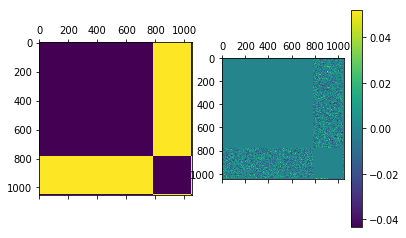

In [6]:

G = G + G.T
W = np.random.normal(0, 0.01, size=G.shape)*G
b = np.random.randn(Nt)*0.01

example = 0
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

Run Algorithm

In [7]:
# Params
bs = 32
iterations = 1000 # Number of gradient updates
b_pos = 1. # multiplier for positive phase energy term
epsilon = 0.5 # Interpelation parameter [0,1]
negative_steps = 20
positive_steps = 4
lr=0.01
lr_v = 0.1

# Init Variables
vt = np.ones_like(W)
vt = np.ones_like(b)
sp_mask = np.zeros(Nt)
sp_mask[-Ny:] = 1

# Summary
energy = []
y_err = []
x_err = []
accuracy = []

EqProp = True


# Parameter Optimization Loop
for iteration in range(iterations):
    
    # Get samples
    samples = np.random.choice(range(train_x.shape[0]), size=bs)
    x = train_x[samples]
    y = train_yo[samples]
    
    #init states variables
    # Mean-Field Type init
#     s0 = np.concatenate([sig_inv(x), np.random.normal(0, 0.01, size=(bs, Ns)), np.random.normal(0, 0.01, size=(bs, Ny))],
#                         axis=1)

    # EqProp Type init
    s0 = np.concatenate([x, np.random.uniform(size=(bs, Ns)), np.random.uniform(size=(bs, Ny))],
                         axis=1)
    
    
    rho0 = sigmoid(s0)
                         
    # Negative Phase Minimization
    s = np.copy(s0)
    
    for step in range(negative_steps):
        rho_s = sigmoid(s)
        
        # Mean-Field Type Update
        # s = (1-epsilon)*s + epsilon*rho_s*(1-rho_s)*(rho_s.dot(W) + 0.*b[np.newaxis, :])
        
        # EqProp Type Update
        s = hardsig(s + epsilon*(s.dot(W) - s))
        
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    s_neg = np.copy(s)
    
    # Mean-Field Type Update
#     rsn = sigmoid(s_neg)
    
#     rsn[:, :Nx] = x

    prediction = [np.argmax(s[:, Nx + Ns:], 1) == np.argmax(y, 1)]
    accuracy += [np.average(prediction)]
    
    
    # Positive Phase
    for step in range(positive_steps):
        rho_s = sigmoid(s)
        
        # Mean-Field Type Update        
        # s = (1-epsilon)*s + epsilon*rho_s*(1-rho_s)*(rho_s.dot(W) )
        # s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*sig_inv(y)
        
        # EqProp Type Update
        s = hardsig(s + epsilon*(s.dot(W) - s))
        s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*y # Clamp Target
        
        
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    # Gradient Update with RMSProp
    s_pos = s
    #
#     rsp = sigmoid(s_pos)
#     rsp[:, :Nx] = x

    # Meaf-Field dw
#     dw = (rsp.T.dot(rsp) - rsn.T.dot(rsn))*G / bs    

    # EqProp dw
    dw = (s_pos.T.dot(s_pos) - s_neg.T.dot(s_neg))*G / bs
    
    #RMSProp
    vt = (1-lr_v)*vt + lr_v*dw**2
    dw = dw / (vt + 10**-8)**0.5
    
    #Update W
    W += lr*dw
    
    # Bias Term (not used)
#     db = rsp.mean(0) - rsn.mean(0)
#     bt = (1-lr_v)*bt + lr_v*db**2
#     db = db / (bt + 10**-8)**0.5
#     b += lr*db
    
    
    energy += [np.average(E(s, W, 0*b))]
    
    # Mean-Field
#     x_err += [ np.sum((x - rsp[:, :Nx])**2, 1).mean() ]
#     y_err += [ np.sum((y - sigmoid(s[:, Nx + Ns:]))**2, 1).mean() ]
    
    # EqProp
    x_err += [ np.sum((x - s_pos[:, :Nx])**2, 1).mean() ]
    y_err += [ np.sum((y - s[:, Nx + Ns:])**2, 1).mean() ]
    print(iteration, end='\r')
    

Text(0.5, 1.0, 'Neg Accuracy')

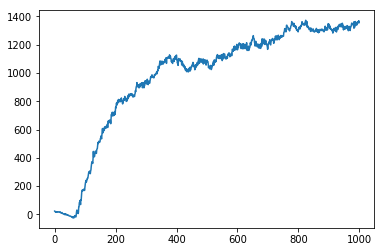

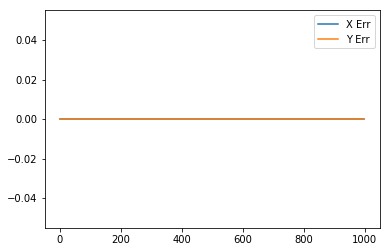

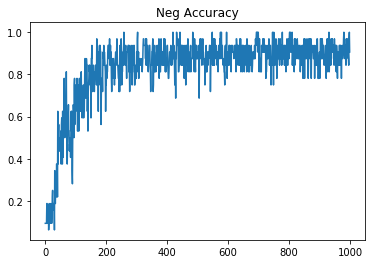

In [8]:
plt.figure()
plt.plot(energy)

plt.figure()
plt.plot( x_err, label='X Err')
plt.plot(y_err, label='Y Err')
plt.legend()

plt.figure()
plt.plot(accuracy)
plt.title('Neg Accuracy')

(array([ 10.,  31.,  54., 152., 256., 255., 178.,  82.,  26.,   6.]),
 array([-0.03276285, -0.02629282, -0.01982278, -0.01335275, -0.00688271,
        -0.00041268,  0.00605736,  0.01252739,  0.01899742,  0.02546746,
         0.03193749]),
 <a list of 10 Patch objects>)

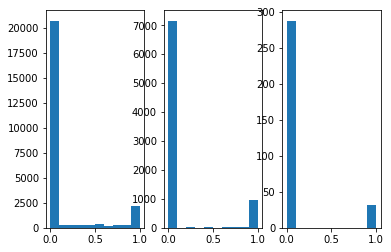

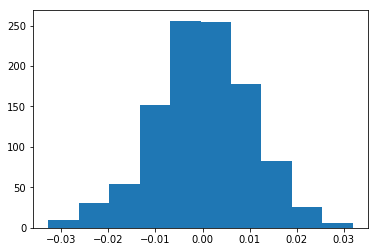

In [9]:
fig, axes = plt.subplots(1, 3)
for ax, idx in zip(axes, [range(Nx), range(Nx, Nx+Ns), range(Nx+Ns, Nx+Ns + Ny)]):
    ax.hist(s[:, idx].ravel())
plt.figure()
plt.hist(b)

(array([ 10.,  31.,  54., 152., 256., 255., 178.,  82.,  26.,   6.]),
 array([-0.03276285, -0.02629282, -0.01982278, -0.01335275, -0.00688271,
        -0.00041268,  0.00605736,  0.01252739,  0.01899742,  0.02546746,
         0.03193749]),
 <a list of 10 Patch objects>)

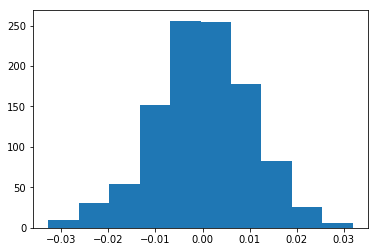

In [10]:
plt.hist(b)


In [11]:
s

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(array([4.60000e+01, 2.82000e+02, 1.55000e+03, 6.78000e+03, 2.76690e+04,
        1.03119e+06, 2.78880e+04, 6.22800e+03, 8.01000e+02, 6.60000e+01]),
 array([-0.88886658, -0.73134847, -0.57383037, -0.41631226, -0.25879416,
        -0.10127605,  0.05624206,  0.21376016,  0.37127827,  0.52879637,
         0.68631448]),
 <a list of 10 Patch objects>)

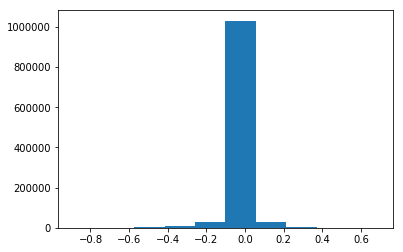

In [12]:
plt.hist(W.ravel())

(array([1.222000e+03, 9.640000e+02, 8.700000e+02, 9.060000e+02,
        1.093234e+06, 1.194000e+03, 7.100000e+02, 7.540000e+02,
        7.600000e+02, 1.886000e+03]),
 array([-3.15892734e+00, -2.52691451e+00, -1.89490168e+00, -1.26288885e+00,
        -6.30876025e-01,  1.13680289e-03,  6.33149631e-01,  1.26516246e+00,
         1.89717529e+00,  2.52918811e+00,  3.16120094e+00]),
 <a list of 10 Patch objects>)

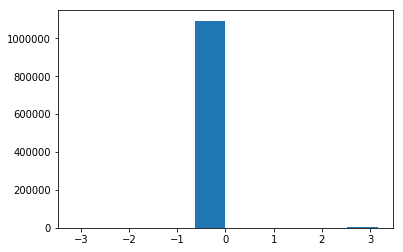

In [13]:
plt.hist(dw.ravel())

(array([1.101958e+06, 1.720000e+02, 1.540000e+02, 8.600000e+01,
        6.000000e+00, 1.200000e+01, 7.200000e+01, 2.000000e+00,
        2.000000e+00, 3.600000e+01]),
 array([1.74787125e-46, 1.62678411e-04, 3.25356823e-04, 4.88035234e-04,
        6.50713645e-04, 8.13392057e-04, 9.76070468e-04, 1.13874888e-03,
        1.30142729e-03, 1.46410570e-03, 1.62678411e-03]),
 <a list of 10 Patch objects>)

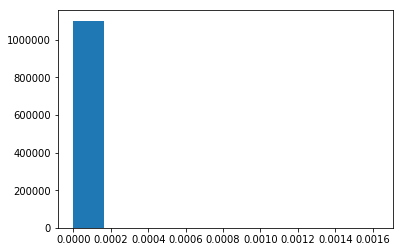

In [14]:
plt.hist(vt.ravel())

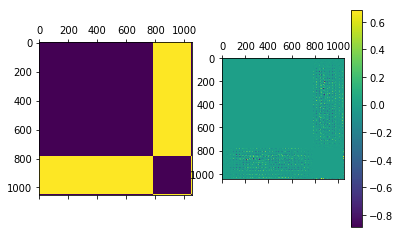

In [15]:
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

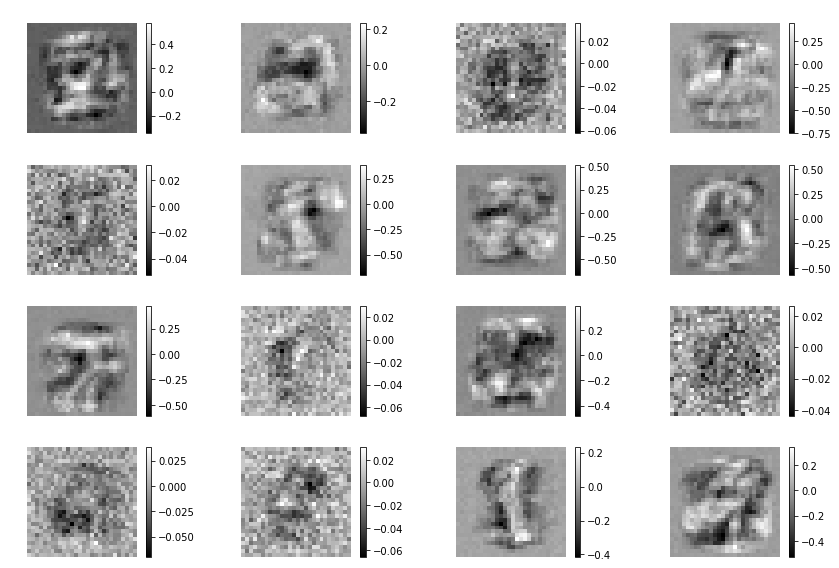

In [16]:
utils.plotmats(W[Nx:Nx + Ns, :Nx])

Sparsity Penatly

Generate Weight Matrix and Vizualize

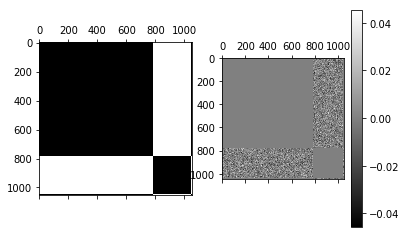

In [202]:

G = G + G.T
W = np.random.normal(0, 0.01, size=G.shape)*G
b = np.random.randn(Nt)*0.01

example = 0
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

Run Algorithm

In [17]:
# Params
bs = 32
iterations = 1000 # Number of gradient updates
b_pos = 1. # multiplier for positive phase energy term
epsilon = 0.5 # Interpelation parameter [0,1]
negative_steps = 20
positive_steps = 4
lr=0.01
lr_v = 0.1
lam = 0.001

# Init Variables
vt = np.ones_like(W)
vt = np.ones_like(b)
sp_mask = np.zeros(Nt)
sp_mask[-Ny:] = 1

# Summary
energy = []
y_err = []
x_err = []
accuracy = []

EqProp = True


# Parameter Optimization Loop
for iteration in range(iterations):
    
    # Get samples
    samples = np.random.choice(range(train_x.shape[0]), size=bs)
    x = train_x[samples]
    y = train_yo[samples]
    
    #init states variables
    # Mean-Field Type init
#     s0 = np.concatenate([sig_inv(x), np.random.normal(0, 0.01, size=(bs, Ns)), np.random.normal(0, 0.01, size=(bs, Ny))],
#                         axis=1)

    # EqProp Type init
    s0 = np.concatenate([x, np.random.uniform(size=(bs, Ns)), np.random.uniform(size=(bs, Ny))],
                         axis=1)
    
    
    rho0 = sigmoid(s0)
                         
    # Negative Phase Minimization
    s = np.copy(s0)
    
    for step in range(negative_steps):
        rho_s = sigmoid(s)
        
        # Mean-Field Type Update
        # s = (1-epsilon)*s + epsilon*rho_s*(1-rho_s)*(rho_s.dot(W) + 0.*b[np.newaxis, :])
        
        # EqProp Type Update
        s = hardsig( soft_thresh(s + epsilon*(s.dot(W) - s), lam / np.linalg.norm(W)))
        
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    s_neg = np.copy(s)
    
    # Mean-Field Type Update
#     rsn = sigmoid(s_neg)
    
#     rsn[:, :Nx] = x

    prediction = [np.argmax(s[:, Nx + Ns:], 1) == np.argmax(y, 1)]
    accuracy += [np.average(prediction)]
    
    
    # Positive Phase
    for step in range(positive_steps):
        rho_s = sigmoid(s)
        
        # Mean-Field Type Update        
        # s = (1-epsilon)*s + epsilon*rho_s*(1-rho_s)*(rho_s.dot(W) )
        # s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*sig_inv(y)
        
        # EqProp Type Update
        s = hardsig( soft_thresh(s + epsilon*(s.dot(W) - s), lam / np.linalg.norm(W)))
        s[:, Nx + Ns:] = (1-b_pos)*s[:, Nx + Ns:] + b_pos*y # Clamp Target
        
        
        s[:, :Nx] = s0[:, :Nx] # Fixed input
        
    # Gradient Update with RMSProp
    s_pos = s
    #
#     rsp = sigmoid(s_pos)
#     rsp[:, :Nx] = x

    # Meaf-Field dw
#     dw = (rsp.T.dot(rsp) - rsn.T.dot(rsn))*G / bs    

    # EqProp dw
    dw = (s_pos.T.dot(s_pos) - s_neg.T.dot(s_neg))*G / bs
    
    #RMSProp
    vt = (1-lr_v)*vt + lr_v*dw**2
    dw = dw / (vt + 10**-8)**0.5
    
    #Update W
    W += lr*dw
    
    # Bias Term (not used)
#     db = rsp.mean(0) - rsn.mean(0)
#     bt = (1-lr_v)*bt + lr_v*db**2
#     db = db / (bt + 10**-8)**0.5
#     b += lr*db
    
    
    energy += [np.average(E(s, W, 0*b))]
    
    # Mean-Field
#     x_err += [ np.sum((x - rsp[:, :Nx])**2, 1).mean() ]
#     y_err += [ np.sum((y - sigmoid(s[:, Nx + Ns:]))**2, 1).mean() ]
    
    # EqProp
    x_err += [ np.sum((x - s_pos[:, :Nx])**2, 1).mean() ]
    y_err += [ np.sum((y - s[:, Nx + Ns:])**2, 1).mean() ]
    print(iteration, end='\r')
    

Text(0.5, 1.0, 'Neg Accuracy')

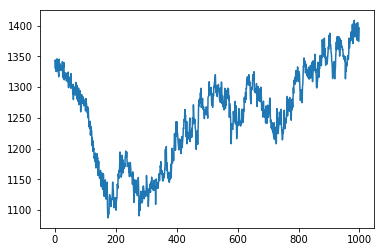

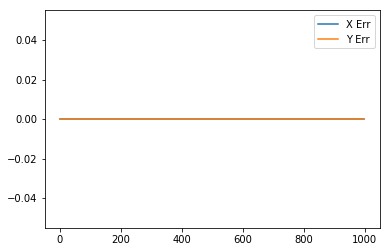

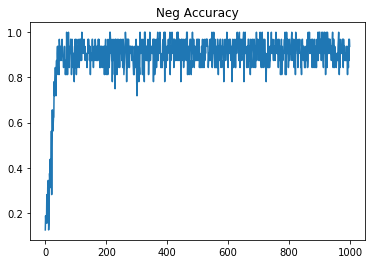

In [18]:
plt.figure()
plt.plot(energy)

plt.figure()
plt.plot( x_err, label='X Err')
plt.plot(y_err, label='Y Err')
plt.legend()

plt.figure()
plt.plot(accuracy)
plt.title('Neg Accuracy')

(array([ 10.,  31.,  54., 152., 256., 255., 178.,  82.,  26.,   6.]),
 array([-0.03276285, -0.02629282, -0.01982278, -0.01335275, -0.00688271,
        -0.00041268,  0.00605736,  0.01252739,  0.01899742,  0.02546746,
         0.03193749]),
 <a list of 10 Patch objects>)

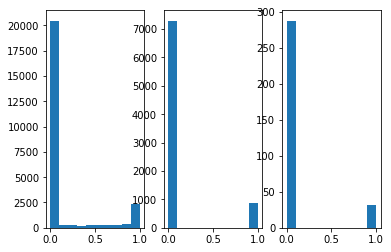

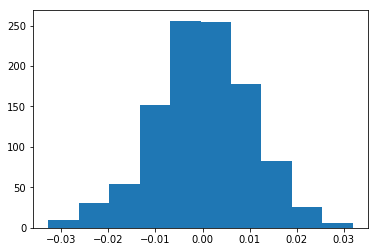

In [19]:
fig, axes = plt.subplots(1, 3)
for ax, idx in zip(axes, [range(Nx), range(Nx, Nx+Ns), range(Nx+Ns, Nx+Ns + Ny)]):
    ax.hist(s[:, idx].ravel())
plt.figure()
plt.hist(b)

(array([ 10.,  31.,  54., 152., 256., 255., 178.,  82.,  26.,   6.]),
 array([-0.03276285, -0.02629282, -0.01982278, -0.01335275, -0.00688271,
        -0.00041268,  0.00605736,  0.01252739,  0.01899742,  0.02546746,
         0.03193749]),
 <a list of 10 Patch objects>)

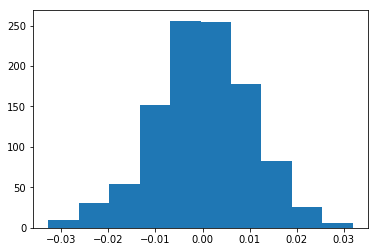

In [20]:
plt.hist(b)


In [21]:
s

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

(array([3.200000e+01, 2.780000e+02, 1.268000e+03, 6.094000e+03,
        2.904600e+04, 1.036783e+06, 2.396000e+04, 4.486000e+03,
        5.130000e+02, 4.000000e+01]),
 array([-1.19652523, -0.98084499, -0.76516476, -0.54948452, -0.33380429,
        -0.11812405,  0.09755618,  0.31323642,  0.52891665,  0.74459689,
         0.96027713]),
 <a list of 10 Patch objects>)

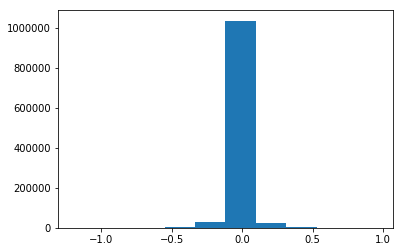

In [22]:
plt.hist(W.ravel())

(array([7.000000e+02, 3.120000e+02, 2.680000e+02, 3.180000e+02,
        1.096902e+06, 2.680000e+03, 2.140000e+02, 2.540000e+02,
        2.920000e+02, 5.600000e+02]),
 array([-3.16159481e+00, -2.52925047e+00, -1.89690614e+00, -1.26456180e+00,
        -6.32217465e-01,  1.26870352e-04,  6.32471206e-01,  1.26481554e+00,
         1.89715988e+00,  2.52950421e+00,  3.16184855e+00]),
 <a list of 10 Patch objects>)

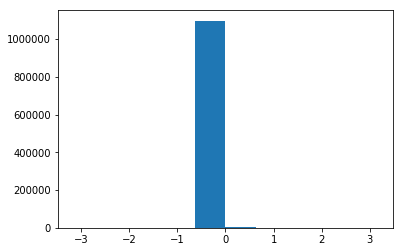

In [23]:
plt.hist(dw.ravel())

(array([1.10206e+06, 1.82000e+02, 9.00000e+01, 2.60000e+01, 6.40000e+01,
        1.00000e+01, 3.80000e+01, 0.00000e+00, 2.00000e+00, 2.80000e+01]),
 array([1.74787125e-46, 1.90830665e-04, 3.81661329e-04, 5.72491994e-04,
        7.63322658e-04, 9.54153323e-04, 1.14498399e-03, 1.33581465e-03,
        1.52664532e-03, 1.71747598e-03, 1.90830665e-03]),
 <a list of 10 Patch objects>)

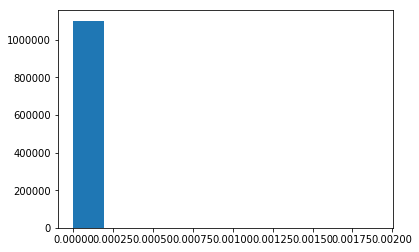

In [24]:
plt.hist(vt.ravel())

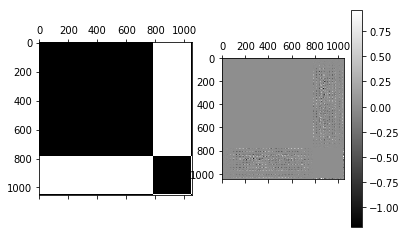

In [25]:
fig, axes = plt.subplots(1,2)
axes[0].matshow(G)
axes[1].matshow(W)
plt.colorbar(axes[1].matshow(W), ax=axes[1])

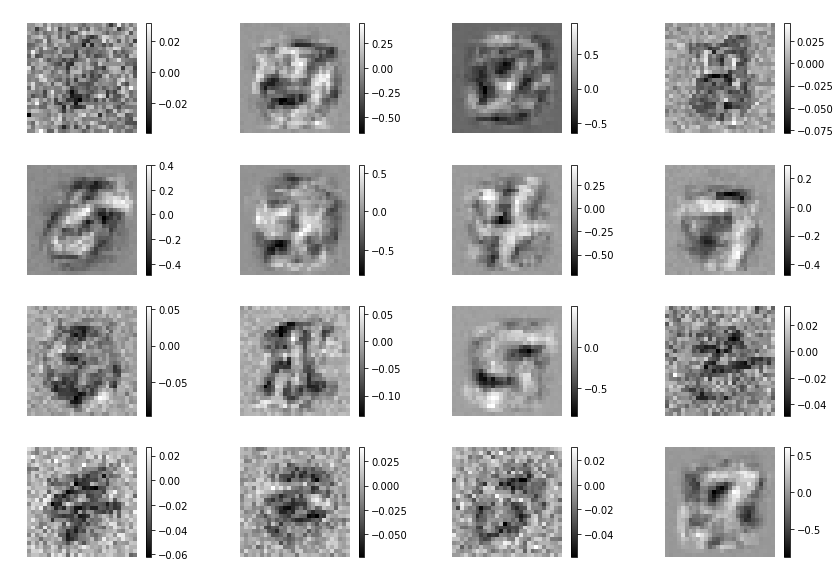

In [26]:
utils.plotmats(W[Nx:Nx + Ns, :Nx])